# Example: DESHIMA 2.0 sensitivity calculation

# Introduction

This notebook uses the `desim` package to make a plot that compares the MDLF of DESHIMA 2.0 (baseline/goal) and DESHIMA 1.0.

## Header

In [1]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

## Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15 ## font size, cannot be in the same cell as `%matplotlib inline`

# Load desim package
desim_path = '/Users/akira/desim'
import sys
sys.path.append(desim_path)
import desim as dsm

In [3]:
# Physical constants
h = 6.62607004 * 10**-34
k = 1.38064852 * 10**-23
e = 1.60217662 * 10**-19 # electron charge
c = 299792458.
Delta_Al = 188 * 10**-6 * e # gap energy of Al
eta_pb = 0.4

## def: input beam size

In [4]:
# Approximate function based on the values of D2_2V3.pdf, p13
def D2HPBW(F):
    HPBW = 29.*240./(F/1e9) * np.pi / 180. / 60. / 60.
    return HPBW

## def: Ruze loss of the telescope 

In [5]:
# Ruze term of main beam efficiency
def eta_mb_ruze(F, LFlimit, sigma):
    '''F in Hz, LFlimit is the eta_mb at => 0 Hz, sigma in m'''
    eta_mb = LFlimit* np.exp(- (4.*np.pi* sigma * F/c)**2. )
    return eta_mb

eta_mb_ruze(np.asarray([350,492])*1e9,0.8,37e-6)

array([ 0.59582916,  0.44691052])

## Calculate the Minimum Detectable Line Flux

### DESHIMA 2.0 (goal)

In [6]:
F = np.linspace(100,1000,9001)*1e9 # frequency range
# F = 3.5e11 # single frequency
HPBW = D2HPBW(F)
eta_mb = eta_mb_ruze(F=F,LFlimit=0.8,sigma=37e-6) * 0.9 # see specs, 0.9 is from EM, ruze is from ASTE

D2goal_input ={
    'F' : F,
    'pwv':0.5,
    'EL':60.,
    'R' : 500,
    'eta_M1_spill' : 0.99,
    'eta_M2_spill' : 0.90,
    'eta_wo' : 0.99,
    'eta_co' : 0.65, # product of co spillover, qo filter
    'eta_lens_antenna_rad' : 0.81, # D2_2V3.pdf, p14: front-to-back ratio 0.93 * reflection efficiency 0.9 * matching 0.98 * antenna spillover 0.993
    'eta_circuit' : 0.35, # 'Alejandro Efficiency', from the feedpoint of the antenna to being absorbed in the KID.
    'eta_IBF' : 0.6,
    'KID_excess_noise_factor' : 1.1,
    'theta_maj' : HPBW,
    'theta_min' : HPBW,
    'eta_mb' : eta_mb,
    'Tb_cmb' : 2.725,
    'Tp_amb' : 273.,
    'Tp_cabin' : 290.,
    'Tp_co' : 4.,
    'Tp_chip' : 0.12,
    'snr' : 5,
    'obs_hours' :8.,
    'on_source_fraction':0.4*0.9 # ON-OFF 40%, calibration overhead of 10%
}

D2goal = dsm.spectrometer_sensitivity(**D2goal_input)

In [7]:
# Display results for the 350 GHz channel as a table
ind = (D2goal['F']-350e9).abs().idxmin()
D2goal[ind:ind+1].transpose().loc[['eta_inst','NEFD_line']]

,2500
eta_inst,1.616610e-01
NEFD_line,4.254491e-27


In [83]:
D2goal[ind:ind+1].transpose()

,2500
F,3.500000e+11
PWV,5.000000e-01
EL,6.000000e+01
eta_atm,9.015443e-01
R,5.000000e+02
W_F_spec,7.000000e+08
W_F_cont,1.166667e+09
theta_maj,9.640866e-05
theta_min,9.640866e-05
eta_a,4.756452e-01


### DESHIMA 2.0 (baseline)

In [81]:
D2baseline_input = {
    'F' : F,
    'pwv':0.5,
    'EL':60.,
    'R' : 500, # <= Goal is 500
    'eta_M1_spill' : 0.99,
    'eta_M2_spill' : 0.90,
    'eta_wo' : 0.99,
    'eta_co' : 0.65, # product of co spillover, qo filter
    'eta_lens_antenna_rad' : 0.81, # D2_2V3.pdf, p14: front-to-back ratio 0.93 * reflection efficiency 0.9 * matching 0.98 * antenna spillover 0.993
    'eta_circuit' : 0.35 * 0.5, # <= eta_inst Goal 16%, Baseline 8% 
    'eta_IBF' : 0.4, # <= Goal 0.6 
    'KID_excess_noise_factor' : 1.2, # Goal 1.1
    'theta_maj' : HPBW,
    'theta_min' : HPBW,
    'eta_mb' : eta_mb,
    'Tb_cmb' : 2.725,
    'Tp_amb' : 273.,
    'Tp_cabin' : 290.,
    'Tp_co' : 4.,
    'Tp_chip' : 0.12,
    'snr' : 5,
    'obs_hours' :8.,
    'on_source_fraction':0.3*0.8/1.2 # <= Goal 0.4*0.9/1.1
}

D2baseline = dsm.spectrometer_sensitivity(**D2baseline_input)

In [82]:
# Display results for the 350 GHz channel as a table
ind = (D2baseline['F']-350e9).abs().idxmin()
D2baseline[ind:ind+1].transpose().loc[['eta_inst','NEFD_line']]

,2500
eta_inst,8.083049e-02
NEFD_line,7.283524e-27


### DESHIMA 1.0

In [93]:
F_D1 = np.linspace(332,377,100)*1e9 # frequency range
# F = 3.5e11 # single frequency

D1_input ={
    'F' : F_D1,
    'pwv':1.5,
    'EL':60.,
    'R' : 380,
    'eta_M1_spill' : 0.99,
    'eta_M2_spill' : 0.90,
    'eta_wo' : 0.99,
    'eta_co' : 0.65, # product of co spillover, qo filter
    'eta_lens_antenna_rad' : 0.81, # D2_2V3.pdf, p14: front-to-back ratio 0.93 * reflection efficiency 0.9 * matching 0.98 * antenna spillover 0.993
    'eta_circuit' : 0.35 * 0.1, # !! Multiply with a factor to reduce D1 optical effiiciency to ~2%
    'eta_IBF' : 0.6,
    'KID_excess_noise_factor' : 1.0,
    'theta_maj' : 31.4*np.pi/180./60./60.,
    'theta_min' : 22.8*np.pi/180./60./60.,
    'eta_mb' : 0.34,
    'Tb_cmb' : 2.725,
    'Tp_amb' : 273.,
    'Tp_cabin' : 290.,
    'Tp_co' : 4.,
    'Tp_chip' : 0.12,
    'snr' : 5,
    'obs_hours' :8.,
    'on_source_fraction':(1./8.)*0.9 # ON-OFF 40%, calibration overhead of 10%
}

D1 = dsm.spectrometer_sensitivity(**D1_input)

In [94]:
# Display results for the 350 GHz channel as a table
ind = (D1['F']-350e9).abs().idxmin()
D1[ind:ind+1].transpose().loc[['eta_inst','NEFD_line']]

,40
eta_inst,1.616572e-02
NEFD_line,4.563131e-26


In [95]:
D1[ind:ind+1].transpose()

,40
F,3.501818e+11
PWV,1.500000e+00
EL,6.000000e+01
eta_atm,7.657200e-01
R,3.800000e+02
W_F_spec,9.215311e+08
W_F_cont,1.535885e+09
theta_maj,1.522315e-04
theta_min,1.105375e-04
eta_a,1.664043e-01


### Export as CSV

In [12]:
D2goal.to_csv(desim_path + '/examples/output/D2goal.csv',index=False)
D2baseline.to_csv(desim_path + '/examples/output/D2baseline.csv',index=False)
D1.to_csv(desim_path + '/examples/output/D1.csv',index=False)

### Astronomical Lines

In [71]:
# Copied from lineflux.py by Yoichi
def co_luminosity(z, d_l, f_obs, int):
    c1, c2 = 3.25e+07, 1.04e-03
    #Lp  = c1 * int * d_l**2 / (f_obs**2 * (1 + z)**3 )
    L   = c2 * int * d_l**2 * f_obs
    return L


def flux_from_line_luminosity(z, d_l, f_obs, L):
    """
        d_l - luminosity distance (Mpc)
        f_obs - observing frequency (GHz)
        L - line luminosity (L_Sun)
    """
    
    L_for1Jykms = co_luminosity(z, d_l, f_obs,  1.000) ## Lsun
    F_for1Jykms = 1.000 * 1e-26 * (f_obs  * 1e9 / 299792.458) ## W m^-2

    return L * (F_for1Jykms / L_for1Jykms)


## user settings
##............................................................

## total infrared luminosity (L_Sun)
Ltir = 5.e+13

## would you like to use line-to-TIR ratios for dwarf galaxies?
switch_dwarf = False

## line-to-TIR luminosity ratio (L_Sun or Watt)
Rcii_B08, Roiii_B08, Roi_B08 = 1.3e-3, 8.0e-4, 1.0e-3 ## from Brauer+2008
Rcii_DGS, Roiii_DGS, Roi_DGS = 2.5e-3, 5.0e-3, 1.7e-3 ## from Cormier+2015

## rest frequency (GHz)
f_cii, f_oiii, f_oi = 1900.5369, 3393.00062, 4744.8

## redshift
exec(open(desim_path + '/Dl_at_z2.py').read())
#z = concatenate( (arange(0.1,0.5,0.1), arange(0.5,2,0.5), arange(2,6,1)), 1)
#z = concatenate( (arange(0.1,0.5,0.1), arange(0.5,2,0.5), arange(2,12,1)), 1)
#z = concatenate( (arange(0.1,1,0.1), arange(1,8,0.2)), 1)
z = np.array([3,4,5,6,7,8,9,10,11,12])
d_l = Dl_at_z(z) ## luminosity distance (Mpc)

Fcii_B08  = flux_from_line_luminosity(z, d_l, f_cii/(1+z),  Ltir * Rcii_B08)
Foiii_B08 = flux_from_line_luminosity(z, d_l, f_oiii/(1+z), Ltir * Roiii_B08)
Foi_B08   = flux_from_line_luminosity(z, d_l, f_oi/(1+z),   Ltir * Roi_B08)

Fcii_DGS  = flux_from_line_luminosity(z, d_l, f_cii/(1+z),  Ltir * Rcii_DGS)
Foiii_DGS = flux_from_line_luminosity(z, d_l, f_oiii/(1+z), Ltir * Roiii_DGS)
Foi_DGS   = flux_from_line_luminosity(z, d_l, f_oi/(1+z),   Ltir * Roi_DGS)

if switch_dwarf:
    Fcii_DGS, Foiii_DGS, Foi_DGS = Fcii_DGS, Foiii_DGS, Foi_DGS
else:
    Fcii_DGS, Foiii_DGS, Foi_DGS = Fcii_B08, Foiii_B08, Foi_B08

### Plot MDLF

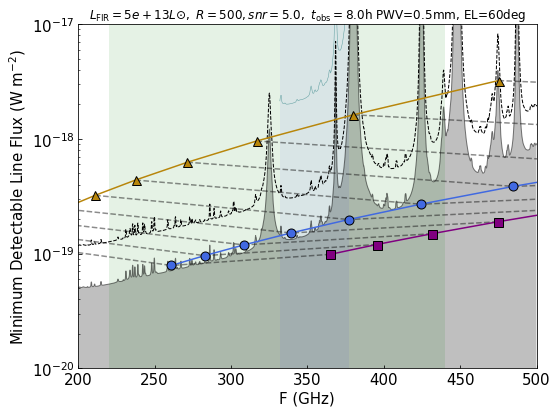

In [73]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

Fmin = 200
Fmax = 500

# Need to crop the data for the filling
ind = (D2goal['F']<Fmax * 1e9) & (D2goal['F']>Fmin * 1e9)

ax.plot(D2baseline['F']/1e9,D2baseline['MDLF'],'--',linewidth=1,color='black',alpha=1,label='D2 baseline')
ax.plot(D2goal['F']/1e9,D2goal['MDLF'],linewidth=1,color='black',alpha=0.5,label='D2 goal')

ax.fill_between(D2goal['F'][ind]/1e9,10**-21,D2goal['MDLF'][ind],
               facecolor='grey',alpha=0.5)
ax.plot(D1['F']/1e9,D1['MDLF'],linewidth=0.5,color='cadetblue',alpha=1,label='D1')
ax.fill_between([220,440],10**-21,[1e-15,1e-15],
               facecolor='green',alpha=0.1) # ,label='D2 coverage'
ax.fill_between([332,377],10**-21,[1e-15,1e-15],
               facecolor='blue',alpha=0.05) # ,label='D1 coverage'

# Astronomical lines
for i in range(len(z)):
    x = np.array( [f_cii, f_oiii] ) / (1 + z[i])
    y = np.array( [Fcii_DGS[i], Foiii_DGS[i]] )
    plt.plot(x, y, '--', color='0.1',alpha=0.5)

for i in range(len(z)):
    x = np.array( [f_oi, f_oiii] ) / (1 + z[i])
    y = np.array( [Foi_DGS[i], Foiii_DGS[i]] )
    plt.plot(x, y, '--', color='0.1',alpha=0.5)

plt.plot(f_cii/(1+z),  Fcii_DGS,  "^-", linewidth=1.5, color='darkgoldenrod', markersize=9,markeredgecolor='black')
plt.plot(f_oiii/(1+z), Foiii_DGS, "o-", linewidth=1.5, color='royalblue', markersize=9,markeredgecolor='black')
plt.plot(f_oi/(1+z),   Foi_DGS,   "s-", linewidth=1.5, color='purple', markersize=9,markeredgecolor='black')


ax.set_xlabel("F (GHz)")
ax.set_ylabel("Minimum Detectable Line Flux ($\mathrm{W\ m^{-2}}$)")
ax.set_yscale('log')
ax.set_xlim([Fmin,Fmax])
ax.set_ylim([10**-20,10**-17])
ax.tick_params(direction='in',which='both')
ax.set_title("$L_\mathrm{FIR}="+"{:.0e}".format(Ltir)+
            "L\mathrm{\odot},\ R="+str(int(D2goal['R'][0]))+", snr=" + str(D2goal['snr'][0]) + ',\ t_\mathrm{obs}=' 
             +str(D2goal['obs_hours'][0])
             +'\mathrm{h}$ PWV=' + str(D2goal['PWV'][0]) + "mm, EL="+str(int(D2goal['EL'][0]))+'deg',
             fontsize=12)
# ax.legend()
plt.tight_layout()
plt.savefig(desim_path + "/examples/output/MDLF_baseline_goal_D1_lines.pdf",bbox_inches="tight",transparent=True)